# Dataset 1


## Installs

In [ ]:
!pip install modAL

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install opendatasets


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import opendatasets as od
import pandas as pd
import numpy as np
import random
from sklearn.model_selection import train_test_split
from modAL.models import ActiveLearner
from sklearn.linear_model import LogisticRegression
from modAL.uncertainty import entropy_sampling
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from functools import partial
from modAL.batch import uncertainty_batch_sampling


## Data

In [ ]:
od.download("https://www.kaggle.com/datasets/brendan45774/test-file")

Skipping, found downloaded files in "./test-file" (use force=True to force download)


In [ ]:
df = pd.read_csv("/content/smoke-detection-dataset/smoke_detection_iot.csv")
df = df.dropna()
df.head()

,Unnamed: 0,UTC,Temperature[C],Humidity[%],TVOC[ppb],eCO2[ppm],Raw H2,Raw Ethanol,Pressure[hPa],PM1.0,PM2.5,NC0.5,NC1.0,NC2.5,CNT,Fire Alarm
0,0,1654733331,20.000,57.36,0,400,12306,18520,939.735,0.0,0.0,0.0,0.0,0.0,0,0
1,1,1654733332,20.015,56.67,0,400,12345,18651,939.744,0.0,0.0,0.0,0.0,0.0,1,0
2,2,1654733333,20.029,55.96,0,400,12374,18764,939.738,0.0,0.0,0.0,0.0,0.0,2,0
3,3,1654733334,20.044,55.28,0,400,12390,18849,939.736,0.0,0.0,0.0,0.0,0.0,3,0
4,4,1654733335,20.059,54.69,0,400,12403,18921,939.744,0.0,0.0,0.0,0.0,0.0,4,0


### Imbalancing test


In [ ]:
# class count
class_count_1, class_count_0 = df['Fire Alarm'].value_counts()

# Separate class
class_0 = df[df['Fire Alarm'] == 0]
class_1 = df[df['Fire Alarm'] == 1]# print the shape of the class
print('class 0:', class_0.shape)
print('class 1:', class_1.shape)

class 0: (17873, 16)
class 1: (44757, 16)


total class of 1 and0: 1    17873
0    17873
Name: Fire Alarm, dtype: int64


<Axes: title={'center': 'count (target)'}>

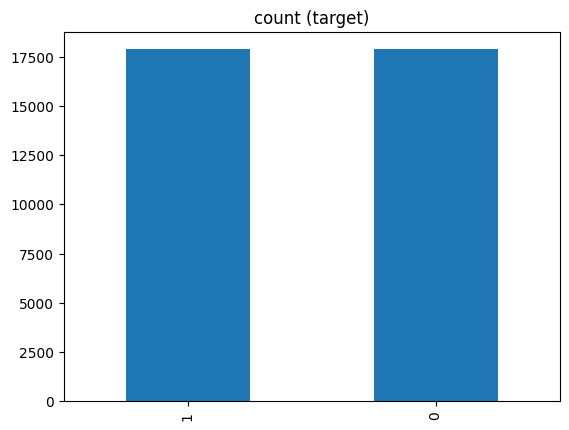

In [ ]:
class_1_under = class_1.sample(class_count_0)

df_balanced = pd.concat([class_1_under, class_0], axis=0)

print("total class of 1 and0:", df_balanced['Fire Alarm'].value_counts())# plot the count after under-sampeling
df_balanced['Fire Alarm'].value_counts().plot(kind='bar', title='count (target)')

### Imbalanced data

In [ ]:
df.drop(['Unnamed: 0', 'UTC'], axis=1, inplace=True)
y_Imb= df["Fire Alarm"]
X_Imb = df.drop(["Fire Alarm"],axis="columns")
X_Imb.isna().sum()

Temperature[C]    0
Humidity[%]       0
TVOC[ppb]         0
eCO2[ppm]         0
Raw H2            0
Raw Ethanol       0
Pressure[hPa]     0
PM1.0             0
PM2.5             0
NC0.5             0
NC1.0             0
NC2.5             0
CNT               0
dtype: int64

In [ ]:
y_Imb = y_Imb.to_numpy()
X_Imb = X_Imb.to_numpy()

### Balanced

In [ ]:
df_balanced.drop(['Unnamed: 0', 'UTC'], axis=1, inplace=True)
y= df_balanced["Fire Alarm"]
X = df_balanced.drop(["Fire Alarm"],axis="columns")
X.isna().sum()

Temperature[C]    0
Humidity[%]       0
TVOC[ppb]         0
eCO2[ppm]         0
Raw H2            0
Raw Ethanol       0
Pressure[hPa]     0
PM1.0             0
PM2.5             0
NC0.5             0
NC1.0             0
NC2.5             0
CNT               0
dtype: int64

In [ ]:
y= y.to_numpy()
X = X.to_numpy()

In [ ]:
X.shape

(35746, 13)

## Models

In [ ]:
def random_sampling(classifier, X_pool):
    n_samples = X_pool.shape[0]
    query_idx = np.random.choice(range(n_samples))
    return query_idx


In [ ]:
class Active_Learning:
  def __init__(self, X, y, estimator, strategy, val, BATCH_SIZE=1) -> None:
    self.val = val
    self.BATCH_SIZE =BATCH_SIZE

    #Data
    random.seed(1)
    X_train, self.X_test, y_train, self.y_test = train_test_split(X, y, test_size=0.3, shuffle=True)
    self.X_pool, self.X_train, self.y_pool, self.y_train  = train_test_split(X_train, y_train, test_size=0.01, shuffle=True)
    if(self.val):
      self.X_train, self.X_val, self.y_train, self.y_val = train_test_split(self.X_train, self.y_train, test_size=0.7, random_state=42)
    print(self.X_train.shape)
    print(self.X_test.shape)
    print(self.X_val.shape)
    print(self.X_pool.shape)
    self.learner = ActiveLearner(
        estimator=estimator,
        query_strategy=strategy,
        X_training=self.X_train, y_training=self.y_train

    )
  # def random_sampling(self, classifier):
  #   n_samples = len(self.X_pool)
  #   query_idx = np.random.choice(range(n_samples))
  #   return query_idx, self.X_pool[query_idx]

  def oracle(self, query_idx):
    # simulate an oracle by asking a human annotator for the label
    return self.y_pool[query_idx]

  def start(self, n_queries):
    for idx in range(n_queries):
        query_idx, query_inst = self.learner.query(self.X_pool)
        y_new = self.oracle(query_idx)
        self.learner.teach(self.X_pool[query_idx].reshape(self.BATCH_SIZE, -1), y_new.reshape(self.BATCH_SIZE, ))
        self.X_pool, self.y_pool = np.delete(self.X_pool, query_idx, axis=0), np.delete(self.y_pool, query_idx)
        if(self.val):
          y_pred = self.learner.predict(self.X_val)
          acc = accuracy_score(self.y_val, y_pred)
          print("Validation Accuracy: {}".format(acc))

    print("Accuracy: {}".format(accuracy_score(self.learner.predict(self.X_test), self.y_test)))


In [ ]:
Learner_0 = Active_Learning(X, y, LogisticRegression(max_iter=1000), random_sampling, True)
Learner_0.start(5)

(75, 13)
(10724, 13)
(176, 13)
(24771, 13)
Validation Accuracy: 0.9715909090909091
Validation Accuracy: 0.9715909090909091
Validation Accuracy: 0.9715909090909091
Validation Accuracy: 0.9715909090909091
Validation Accuracy: 0.9715909090909091
Accuracy: 0.9696008951883626


In [ ]:
Learner_1 = Active_Learning(X, y, LogisticRegression(max_iter=1000), entropy_sampling, True)
Learner_1.start(10)

(75, 13)
(10724, 13)
(176, 13)
(24771, 13)
Validation Accuracy: 0.9659090909090909
Validation Accuracy: 0.9659090909090909
Validation Accuracy: 0.9659090909090909
Validation Accuracy: 0.9715909090909091
Validation Accuracy: 0.9715909090909091
Validation Accuracy: 0.9715909090909091
Validation Accuracy: 0.9715909090909091
Validation Accuracy: 0.9715909090909091
Validation Accuracy: 0.9715909090909091
Validation Accuracy: 0.9715909090909091
Accuracy: 0.9726781051846326


In [ ]:
Learner_2 = Active_Learning(X, y, RandomForestClassifier(), entropy_sampling, True)
Learner_2.start(5)

(75, 13)
(10724, 13)
(176, 13)
(24771, 13)
Validation Accuracy: 0.9431818181818182
Validation Accuracy: 0.9772727272727273
Validation Accuracy: 0.9829545454545454
Validation Accuracy: 0.9886363636363636
Validation Accuracy: 0.9829545454545454
Accuracy: 0.9890898918314062


In [ ]:
#Batch
Learner_3 = Active_Learning(X, y, RandomForestClassifier(), uncertainty_batch_sampling, True, 3)
Learner_3.start(5)

(75, 13)
(10724, 13)
(176, 13)
(24771, 13)
Validation Accuracy: 0.9886363636363636
Validation Accuracy: 0.9886363636363636
Validation Accuracy: 1.0
Validation Accuracy: 0.9943181818181818
Validation Accuracy: 0.9943181818181818
Accuracy: 0.9875046624393883


### Imbalanced Model

In [ ]:
Learner_1 = Active_Learning(X_Imb, y_Imb, LogisticRegression(max_iter=1000), entropy_sampling, True)
Learner_1.start(10)

(131, 13)
(18789, 13)
(308, 13)
(43402, 13)
Validation Accuracy: 0.987012987012987
Validation Accuracy: 0.987012987012987
Validation Accuracy: 0.9805194805194806
Validation Accuracy: 0.9805194805194806
Validation Accuracy: 0.9772727272727273
Validation Accuracy: 0.9772727272727273
Validation Accuracy: 0.9772727272727273
Validation Accuracy: 0.9772727272727273
Validation Accuracy: 0.9772727272727273
Validation Accuracy: 0.9772727272727273
Accuracy: 0.978444834743733


In [ ]:
#Batch
Learner_3 = Active_Learning(X_Imb, y_Imb, RandomForestClassifier(), entropy_sampling, True)
Learner_3.start(5)

(131, 13)
(18789, 13)
(308, 13)
(43402, 13)
Validation Accuracy: 0.9967532467532467
Validation Accuracy: 0.9935064935064936
Validation Accuracy: 0.9967532467532467
Validation Accuracy: 0.9967532467532467
Validation Accuracy: 0.9935064935064936
Accuracy: 0.9981904305710788


## Committee

In [ ]:
from modAL.models import ActiveLearner, Committee
from modAL.disagreement import vote_entropy, KL_max_disagreement
from sklearn.ensemble import RandomForestClassifier

random.seed(1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, shuffle=True)
X_pool, X_train, y_pool, y_train  = train_test_split(X_train, y_train, test_size=0.4, shuffle=True)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)


In [ ]:
# create a committee of three random forest classifiers
n_members = 3
committee = Committee(
    learner_list=[ActiveLearner(
        estimator=RandomForestClassifier(),
        X_training=X_train, y_training=y_train,
        query_strategy=KL_max_disagreement
    ) for _ in range(n_members)]
)

# query the most informative instances
n_queries = 10
batch_size = 1
for idx in range(n_queries):
    query_idx, query_instance = committee.query(X_pool, n_instances=batch_size)
    y_pred = committee.predict(query_instance)
    # supply labels for queried instances
    committee.teach(query_instance, y_pred)

    X_pool, y_pool = np.delete(X_pool, query_idx, axis=0), np.delete(y_pool, query_idx)

    y_pred = committee.predict(X_val)
    acc = accuracy_score(y_val, y_pred)
    print("Accuracy after query {}: {}".format(idx+1, acc))

print("Accuracy: {}".format(accuracy_score(committee.predict(X_test), y_test)))

Accuracy after query 1: 0.9994172494172494
Accuracy after query 2: 0.9988344988344988
Accuracy after query 3: 0.9988344988344988
Accuracy after query 4: 0.9988344988344988
Accuracy after query 5: 0.9988344988344988
Accuracy after query 6: 0.9988344988344988
Accuracy after query 7: 0.9988344988344988
Accuracy after query 8: 0.9988344988344988
Accuracy after query 9: 0.9994172494172494
Accuracy after query 10: 0.9994172494172494
Accuracy: 0.999720260158053


In [ ]:
# create a committee of three random forest classifiers
n_members = 3
committee_2 = Committee(
    learner_list=[ActiveLearner(
        estimator=RandomForestClassifier(),
        X_training=X_train, y_training=y_train,
        query_strategy=KL_max_disagreement
    ),
    ActiveLearner(
        estimator=RandomForestClassifier(),
        X_training=X_train, y_training=y_train,
        query_strategy=vote_entropy
    ),
    ActiveLearner(
        estimator=LogisticRegression(max_iter=1000),
        X_training=X_train, y_training=y_train,
        query_strategy=vote_entropy
    )]
)

# query the most informative instances
n_queries = 10
batch_size = 5
for idx in range(n_queries):
    query_idx, query_instance = committee.query(X_pool, n_instances=batch_size)
    y_pred = committee.predict(query_instance)
    # supply labels for queried instances
    committee.teach(query_instance, y_pred)

    X_pool, y_pool = np.delete(X_pool, query_idx, axis=0), np.delete(y_pool, query_idx)

    y_pred = committee.predict(X_val)
    acc = accuracy_score(y_val, y_pred)
    print("Accuracy after query {}: {}".format(idx+1, acc))

print("Accuracy: {}".format(accuracy_score(committee.predict(X_test), y_test)))

Accuracy after query 1: 0.9994172494172494
Accuracy after query 2: 0.9994172494172494
Accuracy after query 3: 0.9994172494172494
Accuracy after query 4: 0.9994172494172494
Accuracy after query 5: 0.9994172494172494
Accuracy after query 6: 0.9994172494172494
Accuracy after query 7: 0.9994172494172494
Accuracy after query 8: 0.9994172494172494
Accuracy after query 9: 0.9994172494172494
Accuracy after query 10: 0.9994172494172494
Accuracy: 0.9997901951185397


# Dataset 2 Regression

In [ ]:
od.download("https://www.kaggle.com/datasets/harlfoxem/housesalesprediction")
df_reg = pd.read_csv("/content/housesalesprediction/kc_house_data.csv")
df_reg = df_reg.dropna()
df_reg.head()

Skipping, found downloaded files in "./housesalesprediction" (use force=True to force download)


,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,20141209T000000,538000.0,3,2.25,2570,7242,2.0,0,0,...,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,20141209T000000,604000.0,4,3.00,1960,5000,1.0,0,0,...,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503


In [ ]:
df_reg.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21613 entries, 0 to 21612
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21613 non-null  int64  
 1   date           21613 non-null  object 
 2   price          21613 non-null  float64
 3   bedrooms       21613 non-null  int64  
 4   bathrooms      21613 non-null  float64
 5   sqft_living    21613 non-null  int64  
 6   sqft_lot       21613 non-null  int64  
 7   floors         21613 non-null  float64
 8   waterfront     21613 non-null  int64  
 9   view           21613 non-null  int64  
 10  condition      21613 non-null  int64  
 11  grade          21613 non-null  int64  
 12  sqft_above     21613 non-null  int64  
 13  sqft_basement  21613 non-null  int64  
 14  yr_built       21613 non-null  int64  
 15  yr_renovated   21613 non-null  int64  
 16  zipcode        21613 non-null  int64  
 17  lat            21613 non-null  float64
 18  long  

In [ ]:
df_reg.drop(['date'], axis=1, inplace=True)


In [ ]:
X_reg= df_reg.drop(["price"], axis =1).to_numpy()
y_reg= df_reg['price'].to_numpy()

In [ ]:
random.seed(1)
X_reg_train, X_reg_test, y_reg_train, y_reg_test = train_test_split(X_reg, y_reg, test_size=0.3, shuffle=True)
X_reg_pool, X_reg_train, y_reg_pool, y_reg_train  = train_test_split(X_reg_train, y_reg_train, test_size=0.4, shuffle=True)
X_reg_train, X_reg_val, y_reg_train, y_reg_val = train_test_split(X_reg_train, y_reg_train, test_size=0.2, random_state=42)

### Models

In [ ]:
from modAL.models import ActiveLearner, CommitteeRegressor
from modAL.disagreement import max_std_sampling
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score

def Learn(learner, n_queries, X_reg_pool, y_reg_pool, X_reg_val, y_reg_val, X_reg_test, y_reg_test,batch_size=1):
  # query the most informative instances
  for idx in range(n_queries):
      query_idx, query_instance = learner.query(X_reg_pool, batch_size)
      y_pred= y_reg_pool[query_idx]
      #print(X_reg_pool[query_idx].shape)
      # print(y_pred)
      # print(query_idx)
      learner.teach(X_reg_pool[query_idx], y_pred)
      X_reg_pool, y_reg_pool = np.delete(X_reg_pool, query_idx, axis=0), np.delete(y_reg_pool, query_idx)
      y_pred, _= learner.predict(X_reg_val, return_std=True)
      acc = r2_score(y_reg_val, y_pred)
      print("Accuracy after query {}: {}".format(idx+1, acc))

  print("Accuracy: {}".format(r2_score(learner.predict(X_reg_test), y_reg_test)))

In [ ]:
committee_2 = CommitteeRegressor(
    learner_list=[ActiveLearner(
        estimator=LinearRegression(),
        X_training=X_reg_train, y_training=y_reg_train,
        query_strategy=max_std_sampling
    )])


Learn(committee_2,  10, X_reg_pool, y_reg_pool, X_reg_val, y_reg_val, X_reg_test, y_reg_test)

Accuracy after query 1: 0.7072681077079637
Accuracy after query 2: 0.7072455853135111
Accuracy after query 3: 0.7072210092991259
Accuracy after query 4: 0.707218634266046
Accuracy after query 5: 0.7072244098025051
Accuracy after query 6: 0.7072230569330278
Accuracy after query 7: 0.7072231135445188
Accuracy after query 8: 0.7071995764860848
Accuracy after query 9: 0.7071462537013744
Accuracy after query 10: 0.7071421092318955
Accuracy: 0.5561474508053382


In [ ]:
# create a committee of three random forest regressors
committee = CommitteeRegressor(
    learner_list=[ActiveLearner(
        estimator=LinearRegression(),
        X_training=X_reg_train, y_training=y_reg_train,
        query_strategy=max_std_sampling
    ),
    ActiveLearner(estimator=RandomForestRegressor(bootstrap=True),
        X_training=X_reg_train, y_training=y_reg_train,
        query_strategy=max_std_sampling
    ),
     ActiveLearner(estimator=RandomForestRegressor(),
        X_training=X_reg_train, y_training=y_reg_train,
        query_strategy=max_std_sampling
    )]
)

Learn(committee,  10, X_reg_pool, y_reg_pool, X_reg_val, y_reg_val, X_reg_test, y_reg_test)

Accuracy after query 1: 0.8501330276263401
Accuracy after query 2: 0.8460312020028449
Accuracy after query 3: 0.839992008947152
Accuracy after query 4: 0.8335338831248187
Accuracy after query 5: 0.8357011795723098
Accuracy after query 6: 0.8355898155228502
Accuracy after query 7: 0.836213006601105
Accuracy after query 8: 0.8329333405690884
Accuracy after query 9: 0.8346112010171371
Accuracy after query 10: 0.8341527638054314
Accuracy: 0.7732301677975764
